# Предсказание эффективности обогащения золотой руды

Золотодобывающая компания разрабатывает решения для эффективной работы промышленных предприятий, в связи с чем перед нами поставлена задача по обучении модели на основе представленных данных о переработке руды в золото.

В результате решения данного кейса модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. На основании этих данных планируется оптимизация производства, что поможет избежать запуска предприятий с убыточными характеристиками.

**Стадии технологического процесса:**

**1. Флотация:** во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).


**2. Очистка:** черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Технологический процесс:**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


**Параметры этапов:**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков:**

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**Метрика качества работы модели:**

$
sMAPE = 0.25 * sMAPE(rougher) + 0.75 * sMAPE(final)
$

## Извлечем и первичный анализ представленных данных

### Импортируем библиотеки, которые будут использоваться в проекте

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings
from scipy.interpolate import interp1d
from scipy import stats as st
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    roc_auc_score, 
    roc_curve, 
    make_scorer
)
from sklearn.metrics import (
    classification_report, 
    mean_squared_error,
    r2_score, 
    mean_absolute_error, 
    classification_report
)
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler)

### Извлечение данных

In [2]:
train_pth1 = 'C:\\Dataset\\gold_recovery_train_new.csv'
test_pth1 = 'C:\\Dataset\\gold_recovery_test_new.csv'
full_pth1 = 'C:\\Dataset\\gold_recovery_full_new.csv'
train_pth2 = '/datasets/gold_recovery_train_new.csv'
test_pth2 = '/datasets/gold_recovery_test_new.csv'
full_pth2 = '/datasets/gold_recovery_full_new.csv'
# путь в тренажере и на PC


if os.path.exists(train_pth1) & \
os.path.exists(test_pth1) & \
os.path.exists(full_pth1):
    train = pd.read_csv(train_pth1)
    test = pd.read_csv(test_pth1)
    full = pd.read_csv(full_pth1)
elif os.path.exists(train_pth2) & \
os.path.exists(test_pth2) & \
os.path.exists(full_pth2):
    train = pd.read_csv(train_pth2)
    test = pd.read_csv(test_pth2)
    full = pd.read_csv(full_pth2)
else:
    print(
        "Проверьте правильность пути к датасету"
    )

pd.set_option('display.max_columns', 90)

In [3]:
train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Очевидно, в данных имеются пропуски. Обработаем их позже

### Проверим корректность рассчета эффективности обогащения

In [5]:
def rougher_output_recovery(dataframe):
    C = dataframe['rougher.output.concentrate_au'] # Доля золота в концентрате после флотации/очистки
    F = dataframe['rougher.input.feed_au'] #Доля золота в сырье/концентрате до флотации/очистки
    T = dataframe['rougher.output.tail_au'] #Доля золота в отвальных хвостах после флотации/очистки
  
    rougher_output_recovery_dataframe = C * (F - T) / (F * (C - T)) * 100
    
    return rougher_output_recovery_dataframe

rougher_output_recovery_train = rougher_output_recovery(train)
rougher_output_recovery_full = rougher_output_recovery(full)

if (
    rougher_output_recovery_train == train['rougher.output.recovery']
).all():
    print('Эффективность обогащения расчитана корректно')
else:
    print('Эффективность обогащения не соответствует рассчетной.')

Эффективность обогащения не соответствует рассчетной.


In [6]:
out_recov = pd.DataFrame(
    train['rougher.output.recovery'].agg(['median', 'mean'])
)
out_recov.rename(
    columns={'rougher.output.recovery': 'Заданная эффективность'}
)

,Заданная эффективность
median,85.299462
mean,82.704502


In [7]:
pd.DataFrame(
    rougher_output_recovery_train.agg(['median', 'mean']),
    columns=['Расчетная эффективность']
)

,Расчетная эффективность
median,85.299462
mean,82.704502


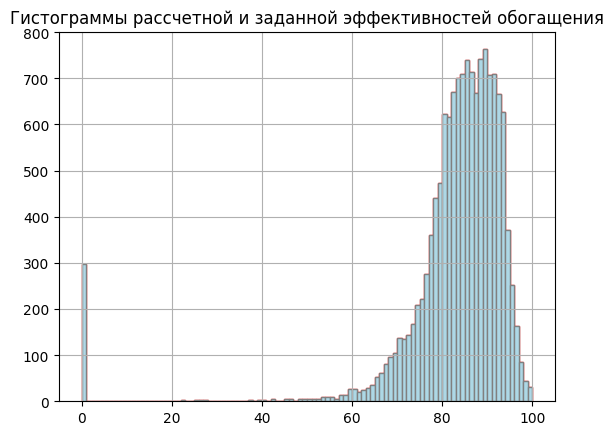

In [8]:
train['rougher.output.recovery'].hist(
    bins=100, color = "black", ec="red"
)
rougher_output_recovery_train.hist(
    bins=100, color = "lightblue", ec="grey"
)

plt.title(
    "Гистограммы рассчетной и заданной эффективностей обогащения"
)
plt.show()

Не заметно расхождений между заданной и расчетной эффективностью. Наблюдается наложение гистограмм.

In [9]:
print(
    'Количество расчетных значений обогащения, отличных от заданных:', 
        (
            train[train['rougher.output.recovery'] != rougher_output_recovery_train]
        )['rougher.output.recovery'].count()
)

Количество расчетных значений обогащения, отличных от заданных: 7437


In [10]:
time = train[train['rougher.output.recovery'] != rougher_output_recovery_train].head(1)
# зафиксировали первое расхождение между расчетным  и заданным обогащением

x = (
    time['rougher.output.concentrate_au'] * (
        time['rougher.input.feed_au'] - time['rougher.output.tail_au']
    )
) / (
    time['rougher.input.feed_au'] * (
        time['rougher.output.concentrate_au'] - time['rougher.output.tail_au']
    )
) * 100

print('Разница между расчетным и заданным значениями = {1} (метка даты: {0})'.format(
    *list(time['date']), *list((x - time['rougher.output.recovery']))
)
      )

Разница между расчетным и заданным значениями = 1.4210854715202004e-14 (метка даты: 2016-01-15 01:00:00)


#### Рассчитаем среднюю абсолютную ошибку рассчетного значения обогащения по отношению к заданному в обучающей выборке и в объединенных данных

In [11]:
print('Обучающая выборка MAE =',
      mean_absolute_error(
          train['rougher.output.recovery'], rougher_output_recovery_train
      ))

Обучающая выборка MAE = 9.73512347450521e-15


In [12]:
print('Объединенные данные MAE =',
      mean_absolute_error(
          full['rougher.output.recovery'], rougher_output_recovery_full
      ))

Объединенные данные MAE = 9.874045668302637e-15


<a id='tag_1'></a>

**Вывод:**

Значение средней абсолютной ошибки между расчетным и представленным в данных значениями эффективности обогащения стремится к 0 и равно 9.73512347450521e-15. Это также подтверждается значениями медианы, среднего расчетных и заданных значений, которые равны между собой.

Таким образом, хотя почти в половине обучающего датасета (7437 из 14148) имеется расхождение в данных, они незначительные и ими можно принебречь.

### Посмотрим, какие данные не попали в тестовую выборку

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [14]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [15]:
number = len(full.columns.difference(test.columns))
print('Признаки, не вошедшие в тестовую выборку:')
for indx in range(number):
    print('{}'.format(full.columns.difference(test.columns)[indx]))

Признаки, не вошедшие в тестовую выборку:
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary

**Вывод:**

Тестовые данные содержат информацию о сырье, которое подается в ходе технического процесса флотации и очистки. При этом в датафрейме отсутствуют данные о результатах флотации и очистки, а также информация об отвальных хвостах.

Как следствие также отсутствуют целевые признаки final.output.recovery и rougher.output.recovery, характеризующие эффективность технологического процесса. Их должна предсказать модель.

Согласно представленной информации некоторые параметры недоступны в тестовой выборке, потому что замеряются и/или рассчитываются значительно позже. Соответственно чтобы делать предсказание только по доступным данным нужно удалить из обучающей выборки все данные, которых нет в тестовой выборке. 

### Проведем предобработку данных

#### Удалим из обучающего датасета признаки, отсутствующие в тестовом датасете

In [16]:
ROUGHER_COLUMNS = test.columns # зафиксировали названия столбцов на тестовой выборке
new_train = train[ROUGHER_COLUMNS].copy(deep=True)
display(new_train.head(3))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


#### Преведем данные о дате и времени к формату Datetime, после чего проверим наличие дубликатов

In [17]:
new_train['date'] = pd.to_datetime(
    new_train['date'], format='%Y-%m-%d %H:%M:%S'
)
test['date'] = pd.to_datetime(
    test['date'], format='%Y-%m-%d %H:%M:%S'
)
full['date'] = pd.to_datetime(
    full['date'], format='%Y-%m-%d %H:%M:%S'
)

In [18]:
print(
    'Дубликатов в тестовой выборке: {:.0f}\
    \nДубликатов в обучающей выборке: {:.0f}'.format(
    test['date'].duplicated().sum(), new_train['date'].duplicated().sum()))

Дубликатов в тестовой выборке: 0    
Дубликатов в обучающей выборке: 0


#### В обучающей выборке имеются пропуски

In [19]:
print('Суммарное количество пропусков во всех признаках:',
      new_train.isna().sum().sum())

Суммарное количество пропусков во всех признаках: 1705


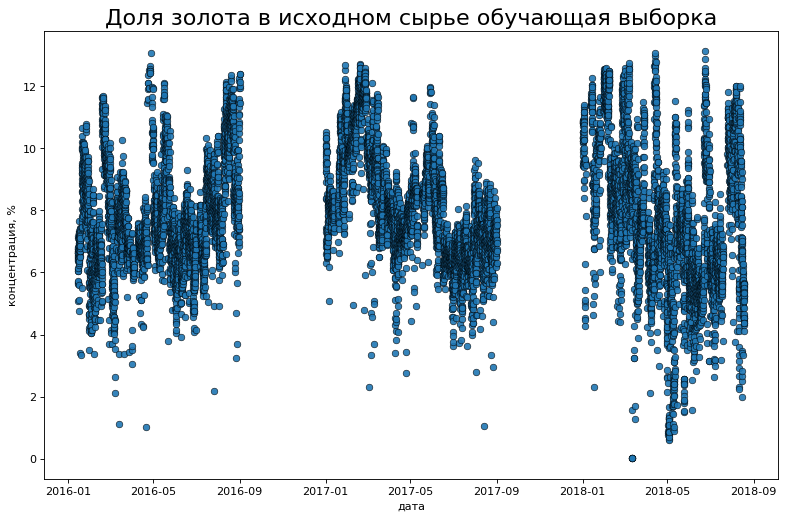

In [20]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])

ax_main.scatter(
    'date',
    'rougher.input.feed_au',
    alpha=.9,
    data=new_train,
    cmap="Set1",
    edgecolors='black',
    linewidths=.5
)

ax_main.set(
    title='Доля золота в исходном сырье обучающая выборка',
    xlabel='дата',
    ylabel='концентрация, %'
)

ax_main.title.set_fontsize(20)

plt.show()

**Вывод:**

В данных имеется некоторое количество выбросов. Странно, что иногда использовалась руда с содержанием золота менее 2%, большинство из которых приходятся на май и сентябрь 2018 года. Похоже, что с октября по январь обогощения золота не происходит. Еще одна странность. 

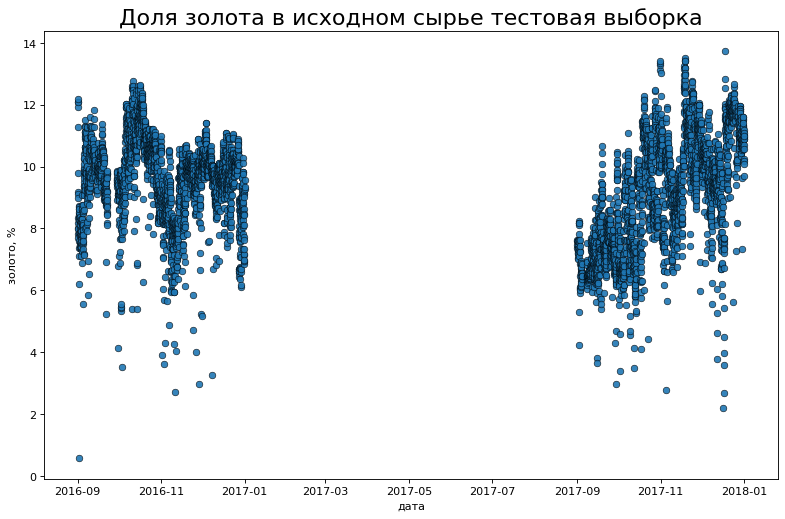

In [21]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])

ax_main.scatter(
    'date', 
    'rougher.input.feed_au', 
    alpha=.9,
    data=test,
    cmap="Set1",
    edgecolors='black',
    linewidths=.5
)
ax_main.set(
    title='Доля золота в исходном сырье тестовая выборка',
    xlabel='дата',
    ylabel='золото, %'
)

ax_main.title.set_fontsize(20)

plt.show()
# Данные с сентября по январь находятся в тестовом датасете

**Вывод:**

Обогащение руды происходит круглый год, при этом данные разделены в зависимости от даты. Если имеется сезонный фактор, модель может работать менее точно. В данных об обогащаемой руде имеются выбросы в виде околонулевого содержания золота.

Заменим пропуски повторением результата последнего наблюдения, поскольку заказчик указал, что зачастую наблюдения за одно и то же время схожи.

### Похоже в данных имеются пропуски. Обработаем их

In [22]:
metric_normal = new_train.drop('date', axis=1) 
# удаляем неинформативный в данном контексте признак даты
metric_normal_agg = metric_normal.agg(
    ['mean',
     'median',
     'std',
     'skew',
     'kurtosis']
)
display(metric_normal_agg)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
mean,133.320659,8.866996,7.322310,0.885588,1608.000064,-488.775525,1608.610983,-489.171786,1608.879407,-489.605549,1542.189963,-483.462423,8.579195,3.522778,474.027714,60.110518,36.312593,7.866577,11.764931,5.854529,11.368685,5.894176,1124.726280,-369.460950,1320.705069,-464.258983,1299.360578,-465.054849,1210.335236,-465.457377,1090.213187,-464.919119,1035.490299,-464.688631,29.613649,-502.223914,24.914403,-503.695706,29.243372,-478.244059,22.656261,-488.924046,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
median,133.018328,8.035811,7.290000,0.888749,1601.824410,-499.909375,1601.818514,-499.938003,1601.574628,-499.871346,1600.168346,-499.831833,8.156092,3.422677,499.454777,55.373885,37.020345,7.649138,11.688702,5.951071,11.384283,5.998460,1001.685708,-300.175125,1301.365123,-499.764620,1300.213385,-499.682528,1200.744308,-499.465285,1050.496363,-499.611447,1000.053757,-499.364335,30.027721,-499.959206,27.022783,-500.014092,28.016530,-499.877837,22.037270,-499.966809,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
std,39.431659,3.361589,0.614062,0.372714,128.394355,35.704184,131.112729,33.604449,134.266898,35.624002,278.316132,47.100934,1.896284,1.073394,104.039838,22.418485,4.956057,1.919506,3.278813,1.104263,3.743672,1.124233,169.310825,93.952787,183.155975,57.401954,213.404094,55.904716,210.431555,55.771393,184.610118,56.602962,175.052279,56.645965,5.800494,60.281705,5.994959,62.837357,5.637309,54.655143,4.996017,41.928112,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
skew,-0.051465,0.422161,-0.478394,0.400098,-1.562975,2.107045,-1.522519,2.436494,-1.651449,1.345262,-1.179745,2.312056,0.511406,0.252212,-1.298230,6.966765,-1.540778,0.110200,0.683715,-0.558233,-0.245122,-0.640623,0.485812,-0.688145,-0.006209,1.217644,0.222543,1.189723,0.071100,1.177944,0.618013,1.154269,1.134020,1.146111,-1.840343,-3.036901,-1.626307,-2.751020,0.008791,-0.933846,0.168338,-0.095334,0.014828,-0.471070,0.068462,-0.461209,0.247317,1.2595

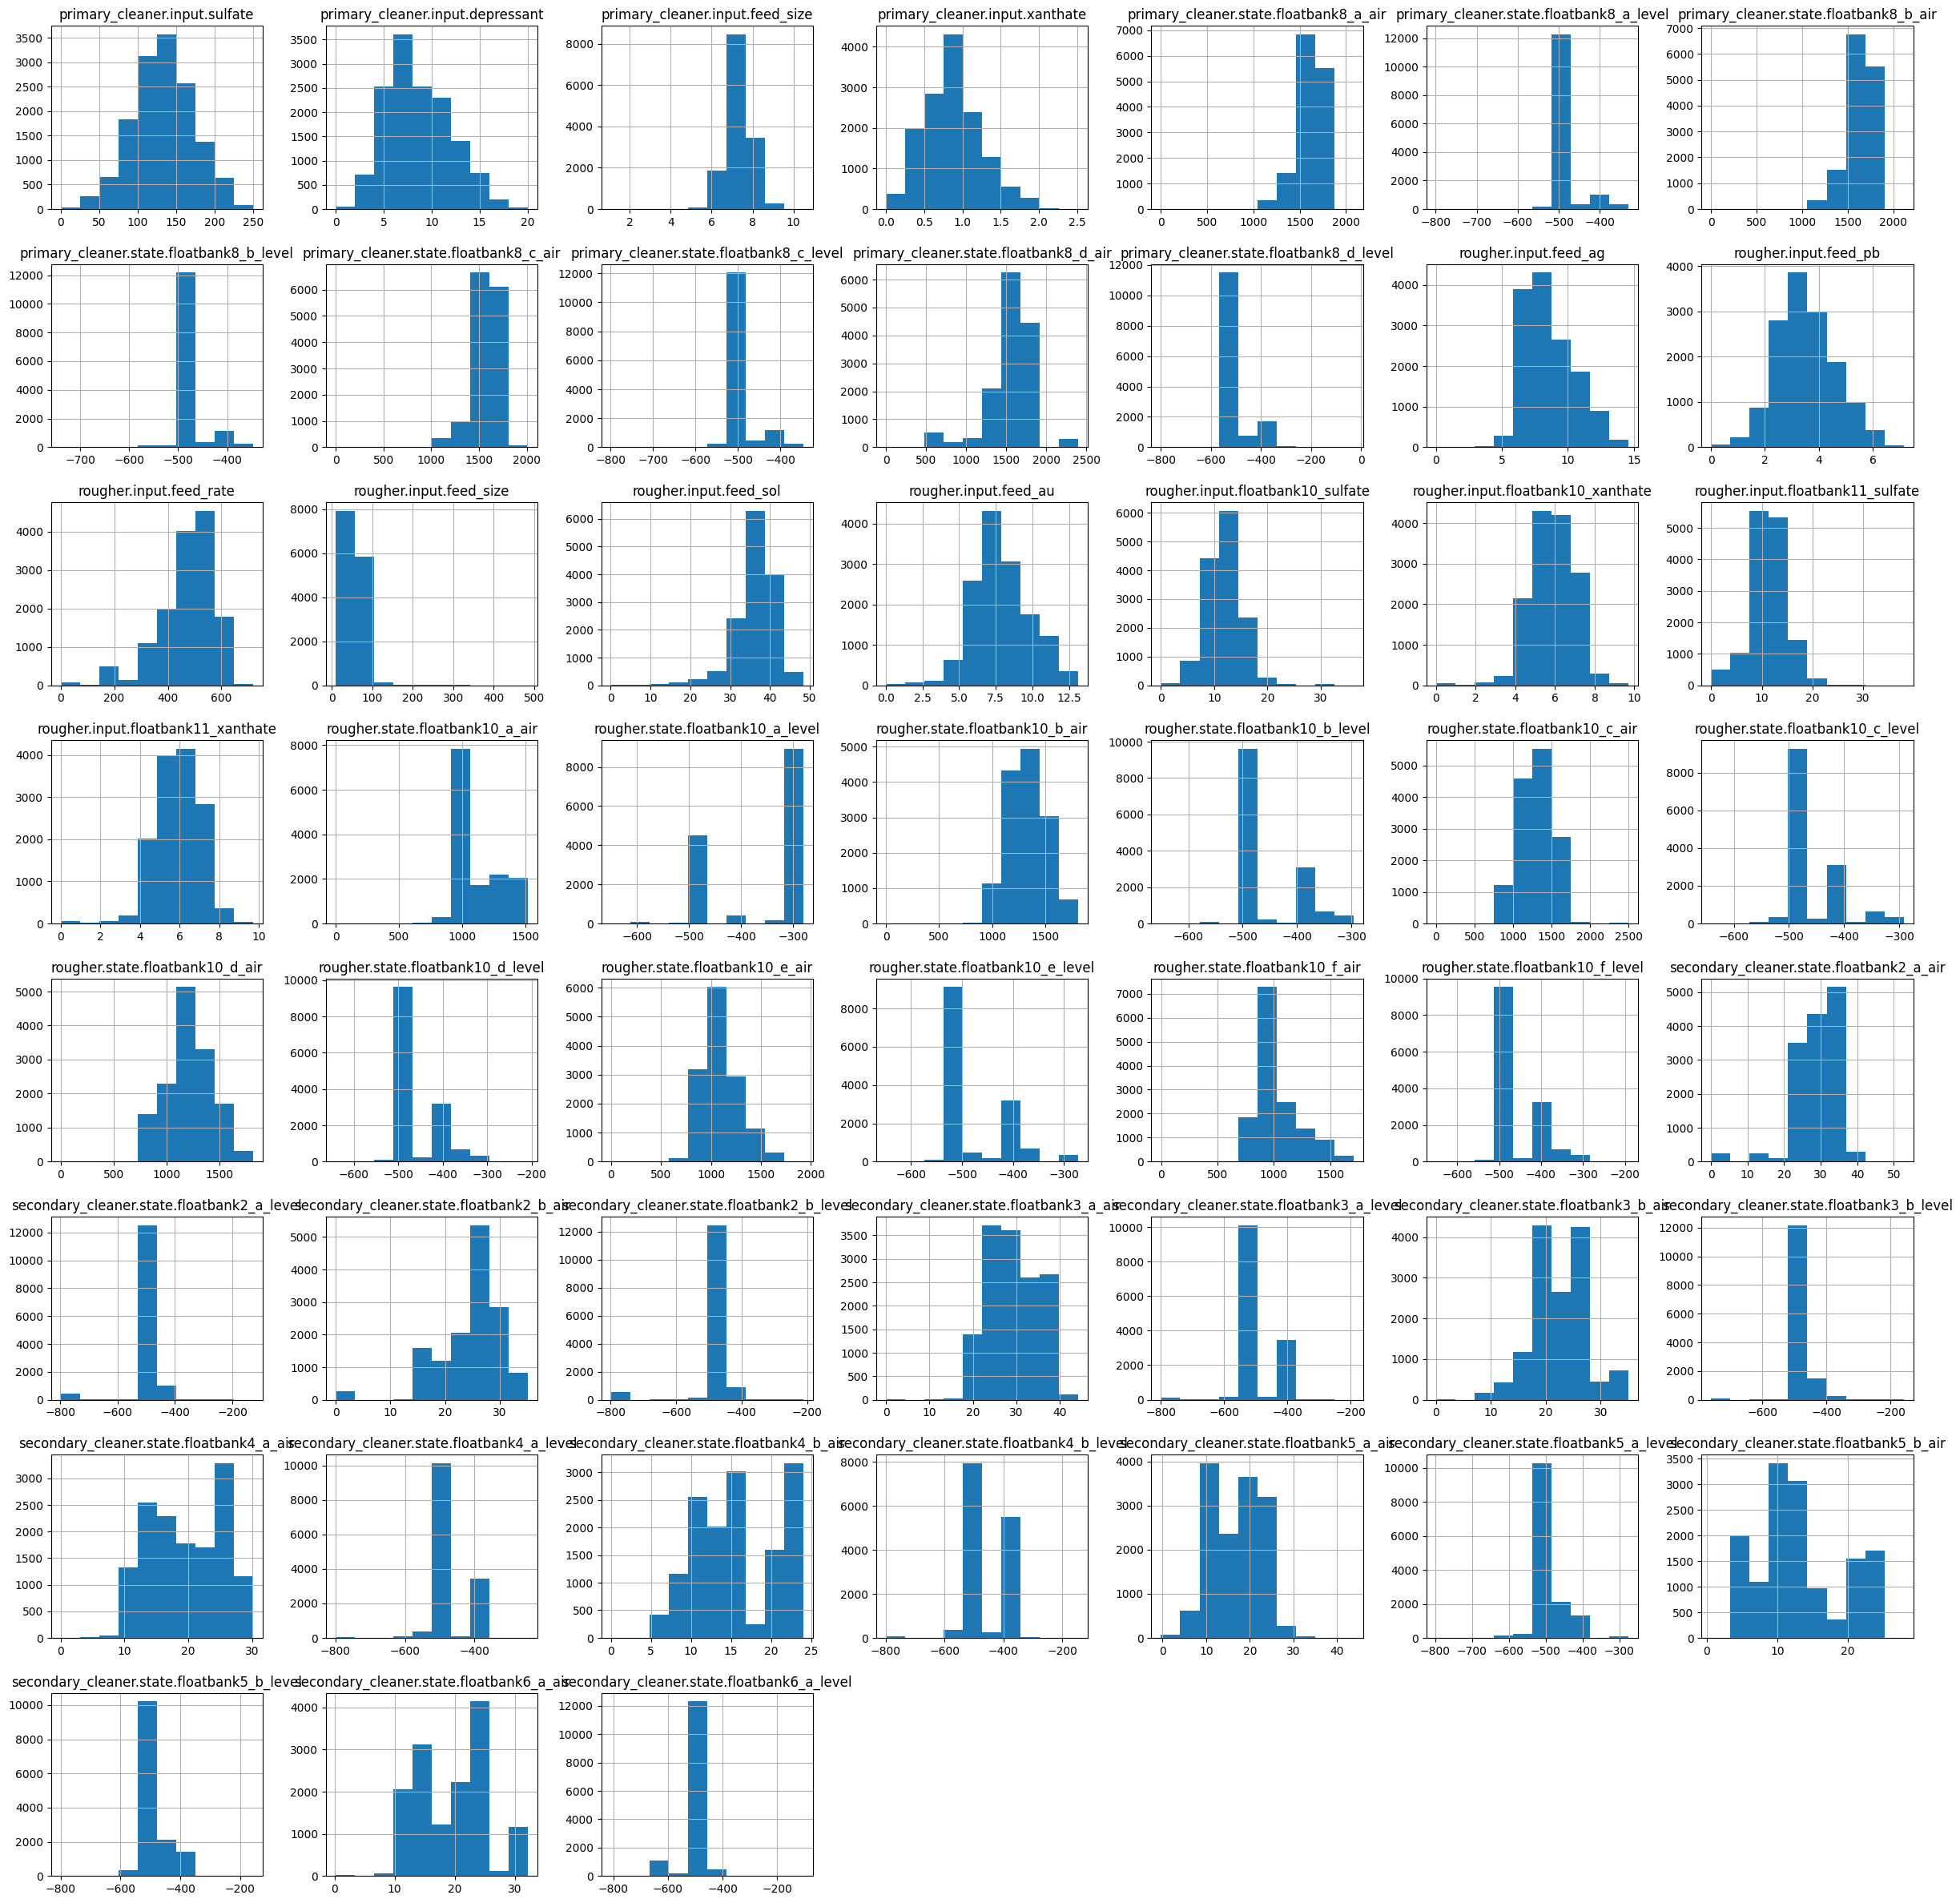

In [23]:
metric_normal.hist(figsize=(30, 30))
plt.title("Гистограммы признаков на обучающей выборке")
plt.show()

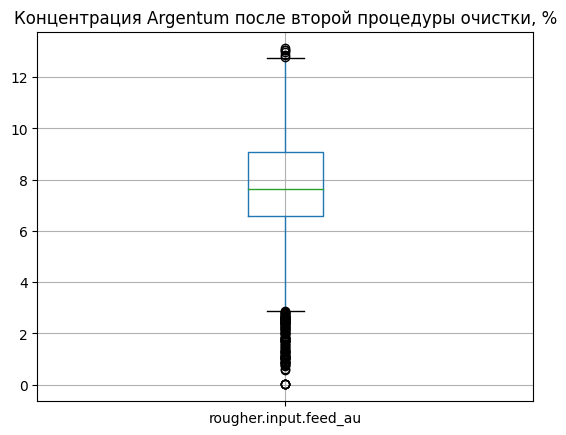

In [24]:
new_train.boxplot(column='rougher.input.feed_au')
plt.title("Концентрация Argentum после второй процедуры очистки, %")
plt.show()

In [25]:
describe_input_au = new_train['rougher.input.feed_au'].describe()
print(describe_input_au) 

count    14149.000000
mean         7.866577
std          1.919506
min          0.010000
25%          6.596217
50%          7.649138
75%          9.066976
max         13.126043
Name: rougher.input.feed_au, dtype: float64


Минимальное содержание золота в руде менее 1%. Похоже, что довольно часто попадается низкосортное сырье содержание золота в котором менее 3%.

In [26]:
new_train = new_train.interpolate(method ='linear', limit_direction ='forward') 
# Запоняем пропуски методом линейной интерполяции для временных рядов

In [27]:
new_train.isna().values.ravel().sum()
# Все пропуски заполнены

0

In [28]:
new_metric = new_train.drop('date', axis=1)
new_metric_agg = new_metric.agg(['mean', 'median', 'std', 'skew', 'kurtosis'])
display(new_metric_agg)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
mean,133.204737,8.853594,7.322310,0.881297,1608.015611,-488.776307,1608.633873,-489.172550,1608.882099,-489.606324,1542.230392,-483.463529,8.579195,3.505983,473.983273,60.097903,36.286912,7.866577,11.746925,5.852998,11.369772,5.773258,1124.717559,-369.470140,1320.724867,-464.261486,1299.381809,-465.057217,1210.335236,-465.457377,1087.860375,-464.919119,1035.490299,-464.688631,29.689851,-502.223759,24.905343,-503.695369,29.242739,-478.245428,22.656283,-488.924848,19.981042,-478.702339,15.486815,-460.236471,16.774662,-483.957101,13.064233,-483.967715,19.576673,-506.804980
median,132.978875,8.034042,7.290000,0.887411,1601.827195,-499.909251,1601.820517,-499.938140,1601.574628,-499.871677,1600.168762,-499.831825,8.156092,3.414267,499.449303,55.269784,36.997632,7.649138,11.661747,5.949895,11.382460,5.992219,1001.682290,-300.175169,1301.367954,-499.764434,1300.214100,-499.682487,1200.744308,-499.465285,1050.351855,-499.611447,1000.053757,-499.364335,30.033684,-499.959207,27.021975,-500.014051,28.016464,-499.877836,22.037443,-499.966823,20.001601,-499.681587,14.975474,-499.388853,17.931987,-499.702424,11.997537,-499.914556,19.984165,-500.061488
std,39.599554,3.374326,0.614062,0.375865,128.384508,35.703044,131.108635,33.603384,134.260708,35.622862,278.310656,47.099453,1.896284,1.089255,104.067492,23.023690,4.971310,1.919506,3.306250,1.107264,3.800514,1.325887,169.308020,93.955826,183.164642,57.400697,213.411496,55.903450,210.431555,55.771393,185.168288,56.602962,175.052279,56.645965,5.809779,60.279577,6.001906,62.835149,5.636711,54.653454,4.995841,41.926739,5.660813,50.738451,5.255553,58.847490,5.831973,37.891666,5.765570,39.206766,5.764495,37.085999
skew,-0.072455,0.406137,-0.478394,0.371140,-1.563177,2.107161,-1.522554,2.436619,-1.651484,1.345359,-1.179770,2.312179,0.511406,0.197013,-1.296872,6.990234,-1.534835,0.110200,0.621746,-0.571955,-0.159084,-1.223042,0.485929,-0.687923,-0.006279,1.217752,0.222402,1.189831,0.071100,1.177944,0.629142,1.154269,1.134020,1.146111,-1.827850,-3.037016,-1.622050,-2.751131,0.009071,-0.933795,0.168330,-0.095281,0.014064,-0.470899,0.068582,-0.461070,0.247428,1.2596

In [29]:
display((metric_normal_agg - new_metric_agg) / metric_normal_agg)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
mean,0.000869,0.001511,0.0,0.004845,-0.000010,-1.600869e-06,-0.000014,-1.563571e-06,-0.000002,-1.582828e-06,-2.621516e-05,-2.286404e-06,0.0,0.004768,0.000094,0.000210,0.000707,0.0,0.001530,0.000262,-0.000096,0.020515,0.000008,-2.487447e-05,-0.000015,-5.391415e-06,-1.634008e-05,-5.091270e-06,0.0,-0.0,0.002158,-0.0,0.0,-0.0,-0.002573,3.103038e-07,0.000364,6.687697e-07,0.000022,-2.862176e-06,-9.880436e-07,-1.640121e-06,0.000221,-1.149658e-05,0.000016,-1.532924e-05,0.000028,-2.229145e-06,2.732967e-05,-2.376785e-06,4.423360e-05,-1.282553e-05
median,0.000297,0.000220,0.0,0.001505,-0.000002,2.493927e-07,-0.000001,-2.731582e-07,0.000000,-6.633711e-07,-2.600408e-07,1.666296e-08,0.0,0.002457,0.000011,0.001880,0.000614,0.0,0.002306,0.000198,0.000160,0.001040,0.000003,-1.476952e-07,-0.000002,3.726143e-07,-5.497684e-07,8.321498e-08,0.0,-0.0,0.000138,-0.0,0.0,-0.0,-0.000199,-2.059824e-09,0.000030,8.199986e-08,0.000002,2.214777e-09,-7.871617e-06,-2.820523e-08,0.000009,-2.749459e-07,0.000004,-2.304364e-07,0.000013,5.524243e-08,8.298190e-07,-8.200323e-10,5.411544e-07,-1.123754e-07
std,-0.004258,-0.003789,0.0,-0.008455,0.000077,3.194347e-05,0.000031,3.167630e-05,0.000046,3.199331e-05,1.967680e-05,3.144474e-05,0.0,-0.014777,-0.000266,-0.026996,-0.003078,0.0,-0.008368,-0.002717,-0.015183,-0.179370,0.000017,-3.234830e-05,-0.000047,2.188949e-05,-3.468452e-05,2.265100e-05,0.0,0.0,-0.003024,0.0,0.0,0.0,-0.001601,3.529403e-05,-0.001159,3.513800e-05,0.000106,3.090379e-05,3.519927e-05,3.275349e-05,-0.000546,-4.789615e-05,0.000019,-6.634926e-05,-0.000011,2.960695e-05,8.209800e-06,2.925193e-05,-1.360217e-05,-1.820405e-04
skew,-0.407845,0.037958,-0.0,0.072378,-0.000129,-5.534627e-05,-0.000022,-5.139712e-05,-0.000021,-7.227617e-05,-2.200764e-05,-5.297935e-05,0.0,0.218859,0.001046,-0.003369,0.003857,0.0,0.090636,-0.024582,0.350999,-0.909145,-0.000241,3.218982e-04,-0.011293,-8.879061e-05,6.300701e-04,-9.128690e-05,0.0,0.0,-0.018008,0.0,0.0,0.0,0.006788,-3.774383e-05,0.002617,-4.055834e-05,-0.031762,5.508248e-05,4.485163e-05,5.596859e-04,0.051528,3.627964e-04,-0.001759,3.015440e-04,-0.000446,-8.228094e-05,-2.230568e-04,-1.

Среднее метрик изменилось на значение, незначительно

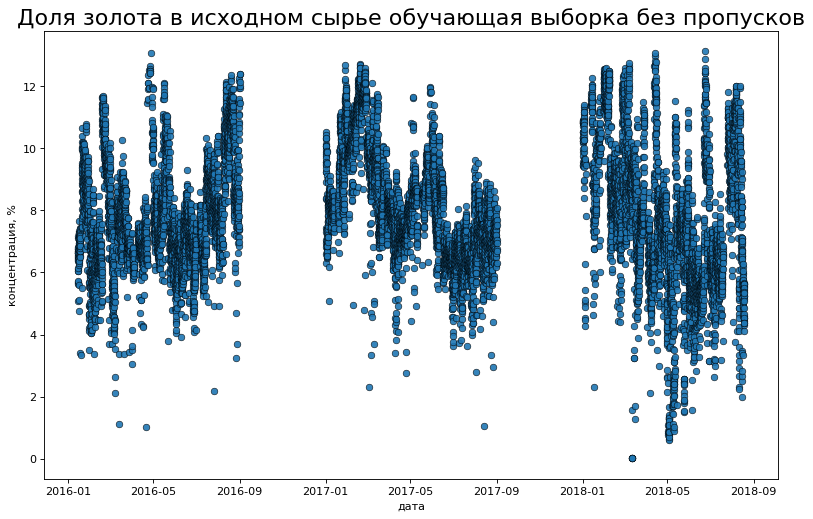

In [30]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])

ax_main.scatter(
    'date',
    'rougher.input.feed_au',
    alpha=.9, 
    data=new_train, 
    cmap="Set1", 
    edgecolors='black', 
    linewidths=.5
)

ax_main.set(
    title='Доля золота в исходном сырье обучающая выборка без пропусков', 
    xlabel='дата',
    ylabel='концентрация, %'
)

ax_main.title.set_fontsize(20)

plt.show()

Данные по обогащаемой руде также сопоставимы

In [31]:
warnings.simplefilter("ignore")
feed_au = new_train.copy(deep=True)
feed_au['year'] = pd.DatetimeIndex(feed_au['date']).year
feed_au['month'] = pd.DatetimeIndex(feed_au['date']).month

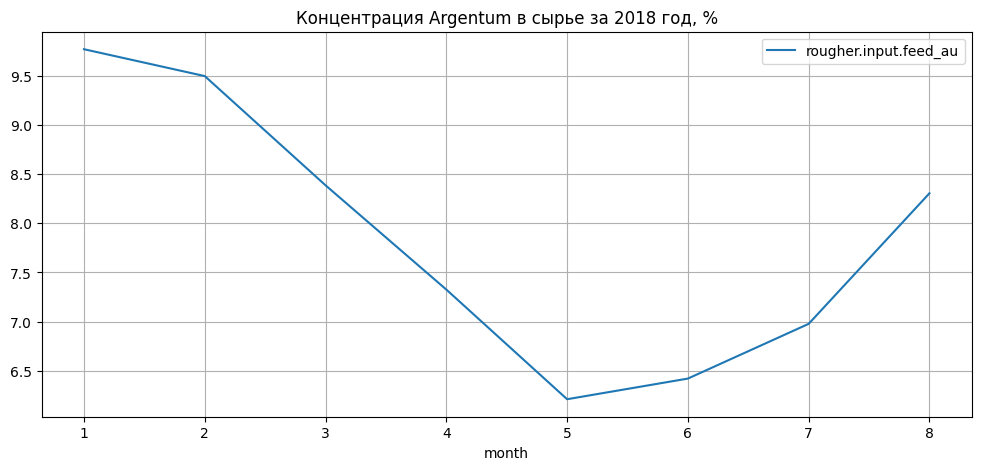

In [32]:
feed_au_2018 = feed_au.query('year == 2018')
(
    feed_au_2018.pivot_table(
        index='month',
        values='rougher.input.feed_au'
    )
    .plot(grid=True, figsize=(12, 5))
)
plt.title(
    "Концентрация Argentum в сырье за 2018 год, %"
)
plt.show()

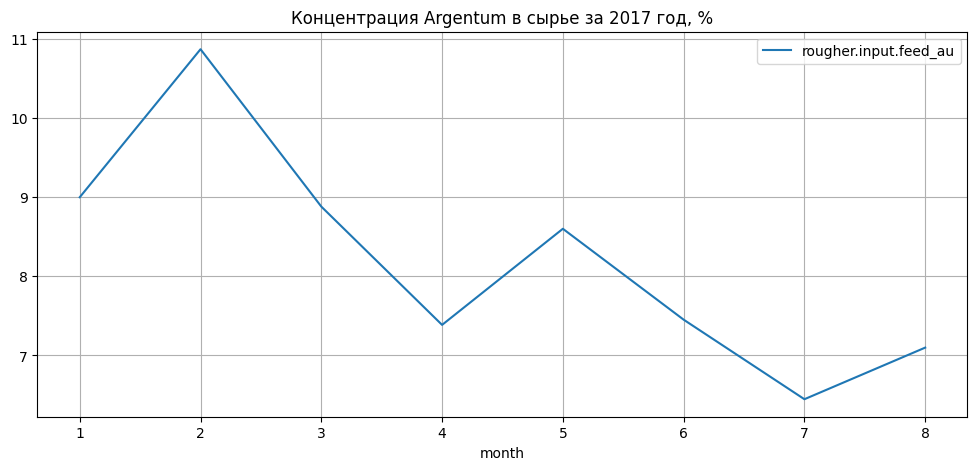

In [33]:
feed_au_2017 = feed_au.query('year == 2017')
(
    feed_au_2017.pivot_table(
        index='month',
        values='rougher.input.feed_au')
    .plot(grid=True, figsize=(12, 5))
)
plt.title(
    "Концентрация Argentum в сырье за 2017 год, %"
)
plt.show()

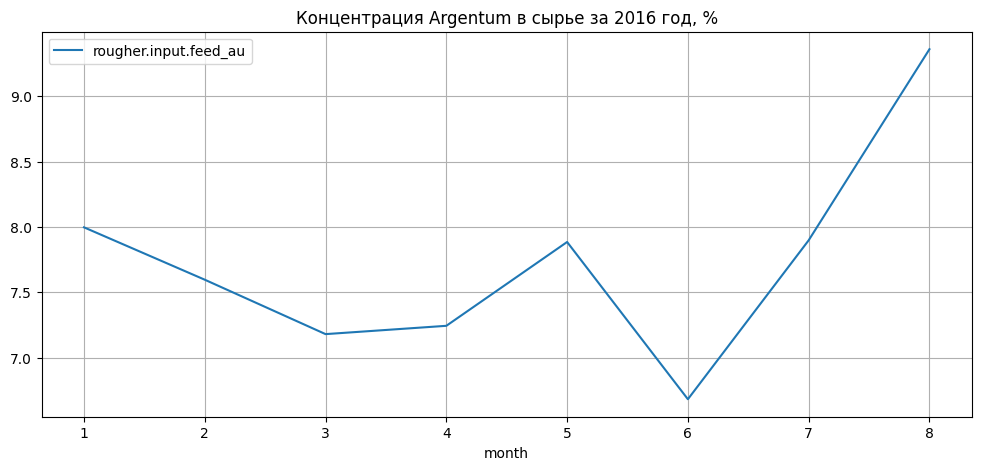

In [34]:
feed_au_2016 = feed_au.query('year == 2016')
(
    feed_au_2016.pivot_table(
        index='month',
        values='rougher.input.feed_au'
    )
    .plot(grid=True, figsize=(12, 5))
)
plt.title(
    "Концентрация Argentum в сырье за 2016 год, %"
)
plt.show()

**Вывод:**

Пропуски заполнил способоб линейной интерполяции для временных рядов, поскольку согласно представленной информации все данные коррелируют между собой, если обогащение осуществлялось примерно в одно время. 

Ощущение, что эффективность обогащения линейно падала в 2018 году вплоть до июня. При этом в предыдущие годы не заметно аналогичных тенденций. При этом в 2018 году заметно наибольшее падение концентрации золота, менее 6.5%

### Добавим целевые признаки для обеих выборок. Делим выборки для обучения двух моделей (черный концентрат и вторая очистка)

#### Пропусков в тестовом датасете немного. Больше всего их в столбце с данными о размере гранул

In [35]:
test['rougher.input.feed_size'].count()

5289

In [36]:
test = test.dropna()
test['rougher.input.feed_size'].count()
# Удалили пропуски. Потеряли около 1% данных

5229

In [37]:
new_train.isna().values.ravel().sum()
# Пропусков более нет

0

### Анализ данных

#### Посмотрим как менялась концентрация металлов в процессе очистки

In [38]:
def mean_metal(dataframe, col, feed):
    mean_metal_data = [
                       dataframe[col[0] + feed].mean(),
                       dataframe[col[1] + feed].mean(),
                       dataframe[col[2] + feed].mean(),
                       dataframe[col[3] + feed].mean(), 
                       dataframe[col[4] + feed].mean(), 
                       dataframe[col[5] + feed].mean(),
                       dataframe[col[6] + feed].mean(), 
                       dataframe[col[7] + feed].mean()
                      ]
    return mean_metal_data
# Функция поможет с построением графика

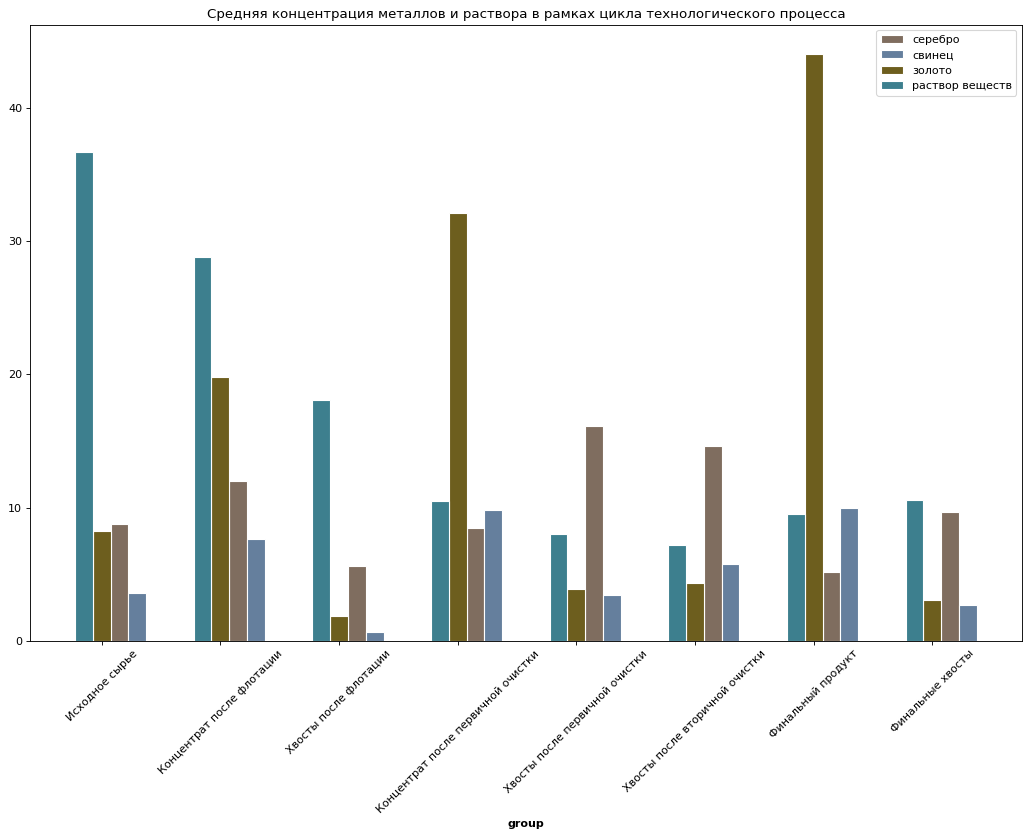

In [39]:
# Концепция кода позаимствована тут: https://www.python-graph-gallery.com/11-grouped-barplot
# Первоначально смотрел на всех данных, но потом вспомнил, что они не обработаны.
# К тому же результаты схожи с обучающей выборкой, и модель мы будем обучать по ней.

feed = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'rougher.output.tail',
    'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail', 
    'secondary_cleaner.output.tail',
    'final.output.concentrate',
    'final.output.tail'
]


barWidth = 0.15
fig = plt.figure(figsize=(16, 10), dpi= 80)

ag_mean = mean_metal(full, feed, '_ag')
pb_mean = mean_metal(full,feed, '_pb')
au_mean = mean_metal(full, feed, '_au')
sol_mean = mean_metal(full, feed, '_sol')

r1 = np.arange(len(ag_mean))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r3, ag_mean, color='#7f6d5f', width=barWidth, edgecolor='white', label='серебро')
plt.bar(r4, pb_mean, color='#657f9d', width=barWidth, edgecolor='white', label='свинец')
plt.bar(r2, au_mean, color='#6d5e1e', width=barWidth, edgecolor='white', label='золото')
plt.bar(r1, sol_mean, color='#3d7f8e', width=barWidth, edgecolor='white', label='раствор веществ')
 
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(ag_mean))], [
    'Исходное сырье', 
    'Концентрат после флотации', 
    'Хвосты после флотации',
    'Концентрат после первичной очистки', 
    'Хвосты после первичной очистки', 
    'Хвосты после вторичной очистки', 
    'Финальный продукт', 
    'Финальные хвосты'])
plt.xticks(rotation=45)
plt.title("Средняя концентрация металлов и раствора в рамках цикла технологического процесса") 
plt.legend()
plt.show()

**Вывод:**

На каждом этапе очистки повышается содержание золота. Наивысшего соотношение содержание золота в среднем достигает после второй очистки и достигает 45%. Т.е. содержание в сравнении с рудами возрасло более, чем в 2 раза. При этом в хвостах остается значительная часть серебра. 

Данные о хвостах после вторичной очистки отображены, поскольку финальные хвосты - это суммарные хвосты от предыдущих этапов.

Почти половина серебра в ходе очистки оказывается в хвостах. В процессе очистки концентрация серебра возрастает только в черном концентрате (с 10% до 20%), после этого она падает в продукте(чуть более 10% в финальном продукте) и возрастает в хвостах.

Доля свинца, как и доля золота в продукте растет. В результате очистки доля свинца возрастает более чем в 2 раза. С менее чем 5% до более чем 10%.

#### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

In [40]:
a = pd.DataFrame({ 'group' : np.repeat('train',len(new_train)), 
                  'feed_size': np.random.normal(10, 5, len(new_train)) })
b = pd.DataFrame({ 'group' : np.repeat('test',len(test)), 
                  'feed_size': np.random.normal(10, 5, len(test))})
a['feed_size'] = train['primary_cleaner.input.feed_size'].reset_index(drop=True)
b['feed_size'] = feed_size_test = test['primary_cleaner.input.feed_size'].reset_index(drop=True)
feed_size = a.append(b)
# Подготовка данных для построения диаграммы размаха для гранул на тестовой и обучающей выборках

In [41]:
def for_boxplot(df, x, y): # функция построения диаграммы размаха
    fig = plt.figure(figsize=(16, 10), dpi= 60)

    sns.boxplot(x=x, y=y, data=df)

    ax = sns.stripplot(x=x, y=y, marker="o", alpha=0.4, data=df, color="gray", jitter=0.2, size=2.0)

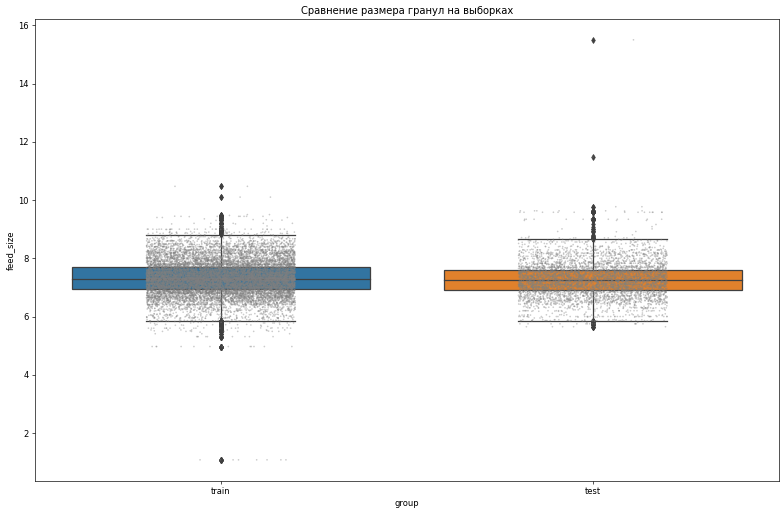

In [42]:
# Концепция кода позаимствована тут: https://www.python-graph-gallery.com/36-add-jitter-over-boxplot-seaborn
for_boxplot(feed_size, 'group', 'feed_size')

plt.title("Сравнение размера гранул на выборках", loc="center")

plt.show()

In [43]:
print(
    new_train['primary_cleaner.input.feed_size'].describe().append(
    test['primary_cleaner.input.feed_size'].describe()
)
     )

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
count     5229.000000
mean         7.271546
std          0.605887
min          5.650000
25%          6.900000
50%          7.250000
75%          7.600000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


**Вывод:**

Размер гранул сопоставимы на тестовой и обучающей выборках. Хотя на обучающей выборке имеется больше выбросов в направлении 1 квартиля, в тестовом же датасете в сторону 3 квартиля. Средний размер гранул на тестовой выборке = 7.271546, в свою очередь размер гранул на обучающей = 7.432335.

#### Посмотрим, как обстоит дело с суммарной концентрацией всех веществ на разных стадиях

In [44]:
input_ = (full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + 
                   full['rougher.input.feed_au'] + full['rougher.input.feed_sol'])
rougher_concentrate_ = (full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + 
                   full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_sol'])
primary_cleaner_ = (full['primary_cleaner.output.concentrate_ag'] + 
                   full['primary_cleaner.output.concentrate_pb'] + 
                   full['primary_cleaner.output.concentrate_au'] + 
                   full['primary_cleaner.output.concentrate_sol'])
final_output_ = (full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + 
                   full['final.output.concentrate_au'] + full['final.output.concentrate_sol'])

mean_substances = [input_.mean(), rougher_concentrate_.mean(), primary_cleaner_.mean(), final_output_.mean()]

stages = [
    'Исходное сырье',
    'Концентрат после флотации', 
    'Концентрат после первичной очистки', 
    'Финальный продукт']
# Среднии для построения графика
print(mean_substances)

[57.407925923279585, 68.18891387342029, 60.949928301036394, 68.72756159662566]


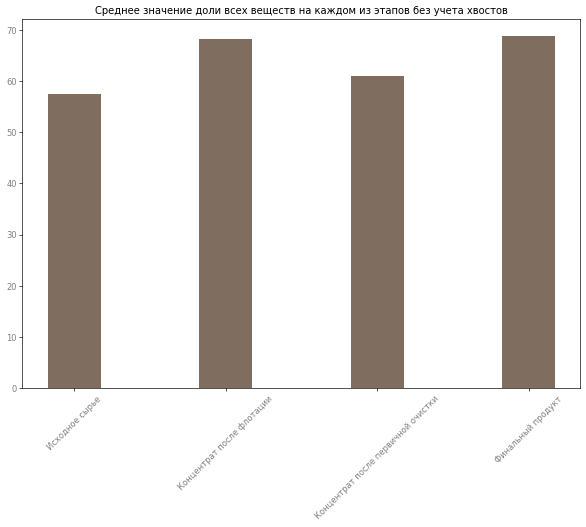

In [45]:
fig = plt.figure(figsize=(12, 8), dpi= 60)

x_pos = np.arange(len(stages))

plt.bar(x_pos, mean_substances, color='#7f6d5f', width=.35)

plt.xticks(x_pos, stages, color='gray')
plt.yticks(color='gray')

plt.xticks(rotation=45)
plt.title("Среднее значение доли всех веществ на каждом из этапов без учета хвостов") 

plt.show()

Если в исходном сырье доля золота составляет около 10%, то в финальном продукте золото превышает 50% от всех веществ.

In [46]:
a = pd.DataFrame(
    { 'group' : np.repeat('Исходное сырье', len(full)),
     'feed_size': np.random.normal(10, 5, len(full))}
)

b = pd.DataFrame(
    { 'group' : np.repeat('Концентрат после флотации', len(full)), 
     'feed_size': np.random.normal(10, 5, len(full))}
)

c = pd.DataFrame(
    { 'group' : np.repeat('Концентрат после первичной очистки', len(full)),
     'feed_size': np.random.normal(10, 5, len(full))}
)

d = pd.DataFrame(
    { 'group' : np.repeat('Финальный продукт',len(full)), 
     'feed_size': np.random.normal(10, 5, len(full))}
)


a['feed_size'] = input_.reset_index(drop=True)

b['feed_size'] = rougher_concentrate_.reset_index(drop=True)

c['feed_size'] = primary_cleaner_.reset_index(drop=True)

d['feed_size'] = final_output_.reset_index(drop=True)

feed_size_ = a.append(b).append(c).append(d)
# Подготовка данных для построения диаграммы размаха для гранул на тестовой и обучающей выборках

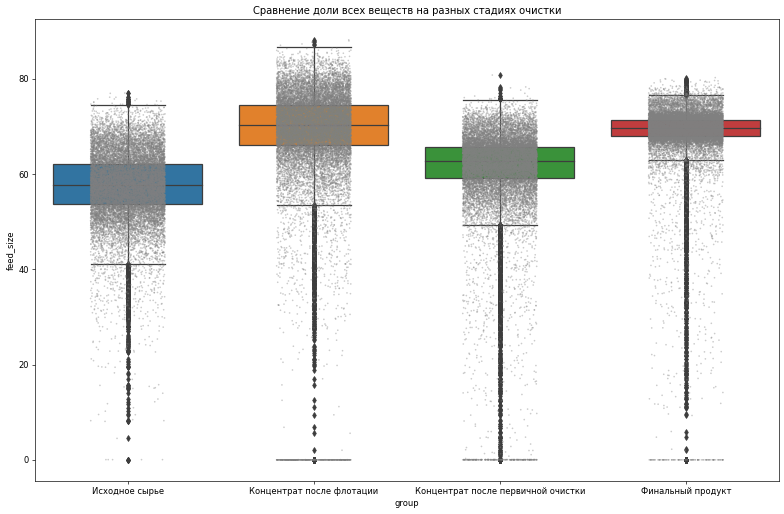

In [47]:
# Концепция кода позаимствована тут: https://www.python-graph-gallery.com/36-add-jitter-over-boxplot-seaborn
for_boxplot(
    feed_size_,
    'group',
    'feed_size'
)

plt.title(
    "Сравнение доли всех веществ на разных стадиях очистки", 
    loc="center"
)

plt.show()

**Вывод:**

Концентрация веществ в продукте после второй очистки доведена в среднем до более чем 69%, что выше параметров используемого сырья. В среднем доля вещества в используемом сырье была около 57%. 

При этом после первой очистки заметен спад концентрации веществ. Скорее всего из-за того, что часть вещества ушла в отвальные хвосты.

Огромное количество выбросов в направлении нуля. Начиная с черного концентрата видим множество нулевых значений. Вероятно имеются проблемы с измерительным оборудованием или иные проблемы, которые ведут к неккоректному собиру данных.

#### Посмотрим количество анамальных данных с концентрацией веществ 0 и 100%

In [48]:
full['input'] = input_
full['rougher_concentrate'] = rougher_concentrate_
full['primary_cleaner'] = primary_cleaner_
full['final_output'] = final_output_
full_drop = full.loc[
    (full['input'] == 0) | (full['input'] == 100) |
    (full['rougher_concentrate'] == 0) | (full['rougher_concentrate'] == 100) |
    (full['primary_cleaner'] == 0) | (full['primary_cleaner'] == 100) |
    (full['final_output'] == 0) | (full['final_output'] == 100)
]
print('Количество аномальных данных:', full_drop['primary_cleaner'].count())

Количество аномальных данных: 557


##### Рассмотрим аномальные данные с привязкой ко времени

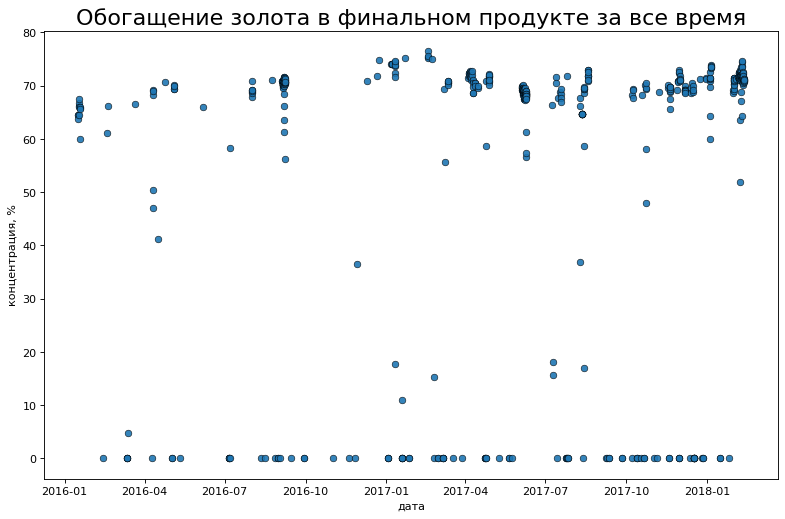

In [49]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])

ax_main.scatter('date', 'final_output', 
                 alpha=.9, data=full_drop, cmap="Set1", edgecolors='black', linewidths=.5)

ax_main.set(title='Обогащение золота в финальном продукте за все время', xlabel='дата', ylabel='концентрация, %')

ax_main.title.set_fontsize(20)

plt.show()

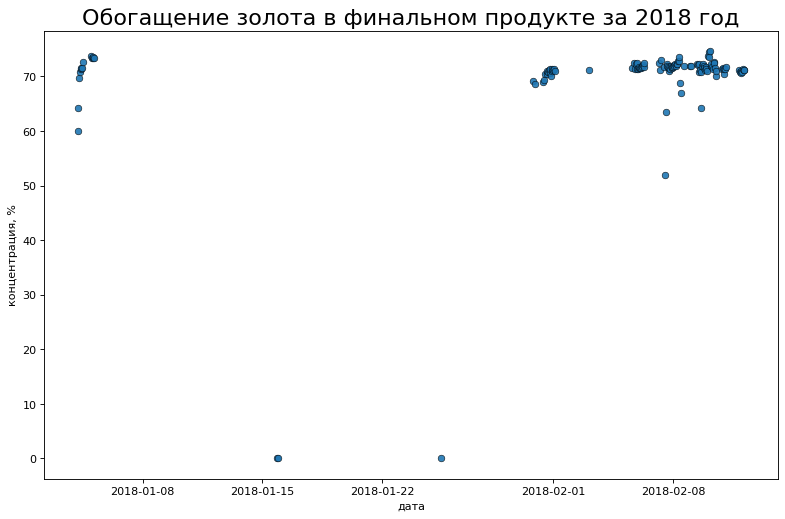

In [50]:
datex = '2018-01-01 00:00:00'
full_drop_2018 = full_drop.query('date >= @datex')

fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

ax_main = fig.add_subplot(grid[:-1, :-1])

ax_main.scatter(
    'date', 
    'final_output', 
    alpha=.9, 
    data=full_drop_2018, 
    cmap="Set1", 
    edgecolors='black', 
    linewidths=.5
)

ax_main.set(
    title='Обогащение золота в финальном продукте за 2018 год',
    xlabel='дата',
    ylabel='концентрация, %'
)

ax_main.title.set_fontsize(20)

plt.show()

In [51]:
full_drop_2018[(
    full_drop_2018['date'] > '2018-01-22 00:00:00'
) & (
    full_drop_2018['date'] < '2018-01-30 00:00:00'
)]['date']

15310   2018-01-25 10:59:59
Name: date, dtype: datetime64[ns]

In [52]:
full_drop_2018[(
    full_drop_2018['date'] > '2018-02-02 00:00:00'
)]['date']

15416   2018-02-03 01:59:59
15474   2018-02-05 13:59:59
15477   2018-02-05 17:59:59
15478   2018-02-05 18:59:59
15479   2018-02-05 19:59:59
                ...        
15620   2018-02-11 23:59:59
15621   2018-02-12 00:59:59
15622   2018-02-12 01:59:59
15623   2018-02-12 02:59:59
15624   2018-02-12 03:59:59
Name: date, Length: 89, dtype: datetime64[ns]

<a id='tag_2'></a>

Похоже, что периодически измерительное оборудование дает сбой. Последний такой сбой наблюдался в период c 5 по 12 февраля 2018 года. Что странно, изредка наблюдаются еденичные аномальные значения (25 января 2018 года). Это может быть связано с человеческим фактором.

###### Удалим аномальные данные

In [53]:
full_drop = list(full_drop['date'])
# удалили аномальные данные

In [54]:
print(
    'Количество строк в обучающей выборке:',
    new_train['date'].count()
)

Количество строк в обучающей выборке: 14149


In [55]:
new_train = new_train.query('date != @full_drop')
print(
    'Количество строк в обучающей выборке без аномальных данных:',
    new_train['date'].count()
)
# Удалили анамальные данные в обучающей выборке

Количество строк в обучающей выборке без аномальных данных: 13725


### Выделим целевой признак, сбалансируем признаки во всех выборках и удалим неиформативные признаки

In [56]:
def target(data, target_signs):
    target_data = []
    for i in data['date']:
        x = list(full[full['date'] == i][target_signs])
        target_data.append(x)
    return target_data
# Функция для вычленения целевых признаков

In [57]:
# Соответственно для определения эффективности финального продукта оставил все данные кроме даты
test_target_final = target(
    test, 
    'final.output.recovery'
)
test_target_final = np.ravel(
    test_target_final
)
test_final = test.drop('date', axis=1)
# Выделили эффективность обогащения финального концентрата тестовый набор

In [58]:
print(test_target_final.shape, test_final.shape)

(5229,) (5229, 52)


In [59]:
test_target_rougher = target(test, 'rougher.output.recovery')
test_target_rougher = np.ravel(test_target_rougher)
# Выделили эффективность обогащения чернового концентрата тестовый набор
rougher_columns = [
       'rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level']
test_rougher = test[rougher_columns]
# Оставил данные, которые отражают только процесс флотации

In [60]:
print(test_target_rougher.shape, test_rougher.shape)

(5229,) (5229, 22)


In [61]:
warnings.simplefilter("ignore")
train_target_final = target(
    new_train,
    'final.output.recovery'
)
train_target_final = np.ravel(train_target_final)
# Выделили эффективность обогащения финального концентрата обучающий набор
train_final = new_train.drop('date', axis=1)
# Соответственно для определения эффективности финального продукта оставил все данные кроме даты

In [62]:
print(train_target_final.shape, train_final.shape)

(13725,) (13725, 52)


In [63]:
warnings.simplefilter("ignore")
train_target_rougher = target(new_train, 'rougher.output.recovery')
train_target_rougher = np.ravel(train_target_rougher)
# Выделили эффективность обогащения чернового концентрата обучающий набор
train_rougher = new_train
for column in new_train.columns:
    if column not in test_rougher:
        train_rougher = train_rougher.drop(column, axis=1)
# Оставил данные, которые отражают только процесс флотации

In [64]:
print(train_target_rougher.shape, train_rougher.shape)

(13725,) (13725, 22)


In [65]:
print('Среднее эффективность обогащения для черного концентрата:\
\n{:.1f}% (обучающая выборка)\
\n{:.1f}% (тестовая выборка)\
\n{:.1f}% (объедененные данные)'.format(
    train_target_rougher.mean(), 
    test_target_rougher.mean(), 
    full['rougher.output.recovery'].mean()
)
     )

Среднее эффективность обогащения для черного концентрата:
84.5% (обучающая выборка)
85.1% (тестовая выборка)
83.3% (объедененные данные)


In [66]:
print('Среднее эффективность обогащения для финального продукта:\
\n{:.1f}% (обучающая выборка)\
\n{:.1f}% (тестовая выборка)\
\n{:.1f}% (объедененные данные)'.format(
    train_target_final.mean(),
    test_target_final.mean(), 
    full['final.output.recovery'].mean()
)
     )

Среднее эффективность обогащения для финального продукта:
66.8% (обучающая выборка)
68.7% (тестовая выборка)
67.1% (объедененные данные)


### Обучим модель

#### Введем функцию по рассчету sMAPE

In [67]:
def smape(target, predict):
    return 1/len(target) * np.sum(
        2 * np.abs(target-predict) / (np.abs(target) + np.abs(predict))*100
    )

smape_score = make_scorer(smape, greater_is_better=False)

### Выбираем модель для расчета эффективности обогащения черного концентрата

#### Модель предсказывающая по среднему для проверки адекватности полученных данных

In [68]:
pseudorandom_model = DummyRegressor(
    strategy='mean'
)
scores = cross_val_score(
    pseudorandom_model,
    train_rougher,
    train_target_rougher,
    cv=10,
    scoring=smape_score
) 
final_score = np.abs(scores.mean())
print('Средний sMAPE(rougher): {:.2f}%'.format(
    final_score
)
     )
# Среднее предсказание хуже других моделей

Средний sMAPE(rougher): 7.74%


In [69]:
def train_model(
    model,
    scoring,
    cv,
    x,
    y,
    param
): # функция для обучения моделей
    
    rs = RandomizedSearchCV(
        model,
        param_distributions=param, 
        scoring=scoring, 
        n_jobs=-1,
        n_iter=100,
        cv=cv
    )
    
    rs.fit(x, y)
    
    print('Средний sMAPE(rougher): {:.2f}%'.format(abs(rs.best_score_)))
        
    return rs

#### Модель линейной регрессии для черного концентрата

In [70]:
%time
model_LR = linear_model.Lasso()

param_LR = {
    'alpha': np.linspace(0, .5, 500)
}

model_LR_rougher = train_model(
                    model_LR,
                    smape_score,
                    10,
                    train_rougher,
                    train_target_rougher,
                    param_LR)

CPU times: total: 0 ns
Wall time: 0 ns
Средний sMAPE(rougher): 5.97%


#### Модель случайного леса для черного концентрата

In [71]:
%%time
forest_model = RandomForestRegressor(random_state=12345)
parametrs_RF = {
    'n_estimators': range (1, 50, 2),
    'max_depth': range (2, 8),
    'min_samples_leaf': range (1, 8),
    'min_samples_split': range (2, 8)
}

model_RF_rougher = train_model(
                    forest_model,
                    smape_score,
                    10,
                    train_rougher,
                    train_target_rougher,
                    parametrs_RF)

Средний sMAPE(rougher): 6.40%
CPU times: total: 8.55 s
Wall time: 10min 40s


Модель линейной регрессии Лассо показала луший средний показатель sMAPE = 5.97%. Модель, предсказывающая по среднему имеет sMAPE = 7.74%, соответственно наша модель выглядит адекватно.

#### Проверим лучшую модель на тестовой выборке

In [72]:
predict_bm_rougher = model_LR_rougher.predict(
    test_rougher
)
smape_rougher = smape(
    test_target_rougher,
    predict_bm_rougher
)
print(
    'На тестовом наборе данных sMAPE = {:.1f}%'.format(
    smape_rougher
)
     )

На тестовом наборе данных sMAPE = 8.1%


На тестовом наборе данных процент ошибки предсказания sMAPE = 8.1%. Очевидно, что модель немного переобучена. 

### Выбираем модель для расчета эффективности финального обогащения

#### Модель предсказывающая по среднему для проверки адекватности полученных данных

In [73]:
pseudorandom_model_f = DummyRegressor(strategy='mean')
scores_f = cross_val_score(
    pseudorandom_model_f,
    train_final,
    train_target_final,
    cv=10,
    scoring=smape_score) 
final_score_f = np.abs(scores_f.mean())
print(
    'Средний sMAPE модели для финального продукта: {:.1f}%'.format(
    final_score_f
)
     )

Средний sMAPE модели для финального продукта: 10.5%


#### Модель линейной регрессии для финального обогащения

In [74]:
%%time
model_LR_f = linear_model.Lasso()

param_LR_f = {
    'alpha': np.linspace(0, .5, 500)
}

model_LR_rougher = train_model(
                    model_LR_f,
                    smape_score,
                    10,
                    train_final,
                    train_target_final,
                    param_LR)

Средний sMAPE(rougher): 9.59%
CPU times: total: 12.8 s
Wall time: 5min 44s


#### Модель случайного леса для финального обогащения

In [75]:
%%time

forest_model_f = RandomForestRegressor(random_state=12345)
parametrs_RF_f = {
    'n_estimators': range (1, 50, 2),
    'max_depth': range (2, 8),
    'min_samples_leaf': range (1, 8),
    'min_samples_split': range (2, 8)
}

model_RF_final = train_model(
                    forest_model_f,
                    smape_score,
                    10,
                    train_final,
                    train_target_final,
                    parametrs_RF_f)

Средний sMAPE(rougher): 8.97%
CPU times: total: 12.2 s
Wall time: 26min 22s


Лучший sMAPE получено на модели случайного леса и равен 8.97%

##### Проверим лучшую модель на тестовом наборе данных

In [76]:
predict_bm_final = model_RF_final.predict(
    test_final
)
smape_final = smape(
    test_target_final,
    predict_bm_final
)
print(
    'На тестовом наборе данных sMAPE = {:.1f}%'.format(
    smape_final
)
     )

На тестовом наборе данных sMAPE = 9.2%


Метрика качества модели sMAPE равна 9.2%, переобучения не заметно.

### Рассчитаем итоговую метрику на основе заданных вводных

In [77]:
final_value_smape = .25 * smape_rougher + .75 * smape_final
print('Итоговое sMAPE: {:.1f}% '.format(final_value_smape))

Итоговое sMAPE: 8.9% 


Лучшая модель показала суммарный sMAPE = 8.9%, соответствующее вероятности ошибочного предсказания модели.

**Выводы:**

1. В половине обучающего датасета (7437 из 14148) имеется расхождение в данных, [они незначительные и ими можно принебречь](#tag_1).

2. Похоже, что [периодически измерительное оборудование дает сбой](#tag_2). Последний такой сбой был в период с 5 по 12 февраля 2018 года. Что странно, изредка наблюдаются еденичные аномальные значения (25 января 2018 года). Это может быть связано с человеческим фактором.


Лучшая модель показала суммарную метрику sMAPE = 9.2%. Соответственно точность предсказания модели равняется 91.1%